# BSc Thesis: Evaluation of Decision Tree and Random Forest Classifiers in the Finance Domain

## Table of Contents
0. Preparation
1. Data Preparation Stage
2. Feature Extraction
3. Classification
4. Evaluation of Models
5. Visualisations

# 0 | Preparation

### Imports

In [2]:
# Data manipulation and arrays
import pandas as pd
import numpy as np

# Machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn import metrics

# Plottig
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display

### Constant variables

In [4]:
# Define filenames for .CSV datasets
MICROSOFT_DATA = "Datasets/Kaggle_SnP500_MSFT_2013-2018.csv"
APPLE_DATA = "Datasets/Kaggle_SnP500_AAPL_2013-2018.csv"
GOOGLE_DATA = "Datasets/Kaggle_SnP500_GOOGL_2013-2018.csv"

# New datasets to be incorporated
HP_DATA = "Datasets/Kaggle_SnP500_HP_2013-2018.csv"
IBM_DATA = "Datasets/Kaggle_SnP500_IBM_2013-2018.csv"
WU_DATA = "Datasets/Kaggle_SnP500_WU_2013-2018.csv"
XRX_DATA = "Datasets/Kaggle_SnP500_XRX_2013-2018.csv"

# Define time horizons to compare classification results for 1-day to 1-year predictions
TIME_HORIZONS = [1, 5, 10, 30, 100, 365]

# 1 | Data Preparation Stage
- Load data and adjust columns as needed
- Extract features for technical analysis
- Define class for later classification
- Detect anomalies in the datasets
- No feature selection needed as embedded in DT and RF

## 1.1. | Load Datasets
- For an apples-to-apples comparison, technology companies are analyzed
- Selected stocks differ in price trends (upward- vs constant- vs downward trend)

Loaded DataFrame has the following columns:
Column 'date' with type <class 'pandas._libs.tslibs.timestamps.Timestamp'> , e.g. 2013-02-08 00:00:00
Column 'open' with type <class 'numpy.float64'> , e.g. 27.35
Column 'high' with type <class 'numpy.float64'> , e.g. 27.71
Column 'low' with type <class 'numpy.float64'> , e.g. 27.31
Column 'close' with type <class 'numpy.float64'> , e.g. 27.55
Column 'volume' with type <class 'numpy.int64'> , e.g. 33318306
Column 'Name' with type <class 'str'> , e.g. MSFT
Column 'month' with type <class 'numpy.int64'> , e.g. 2
df.head():
        date   open   high    low  close    volume  Name  month
0 2013-02-08  27.35  27.71  27.31  27.55  33318306  MSFT      2
1 2013-02-11  27.65  27.92  27.50  27.86  32247549  MSFT      2
2 2013-02-12  27.88  28.00  27.75  27.88  35990829  MSFT      2
3 2013-02-13  27.93  28.11  27.88  28.03  41715530  MSFT      2
4 2013-02-14  27.92  28.06  27.87  28.04  32663174  MSFT      2
Loaded DataFrame has the following columns:
C

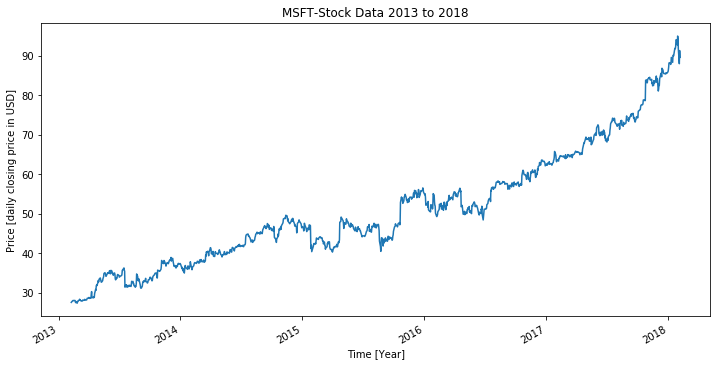

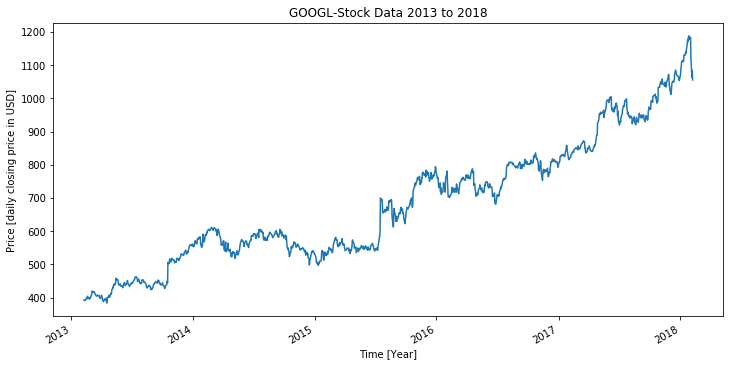

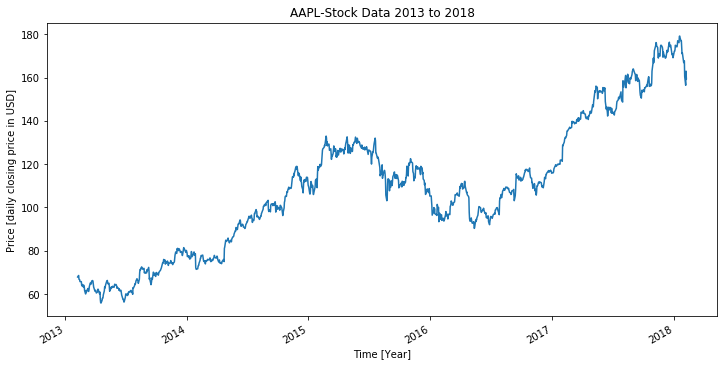

In [65]:
def load_OHLC_data(filename=MICROSOFT_DATA):
    """
    Loads basic stock data (date, name, open, high, low, close) from a given .CSV file and returns a corresponding DataFrame.
    Unnecessary categorical columns are dropped, and necessary columns (e.g. month as number) are added.
    """
    try:
        df = pd.read_csv(filename)
        
        # Visualize loaded time series data
        df["date"] = pd.to_datetime(df["date"])
        df.plot(x='date', y='close', figsize=(12,6), legend=None)
        plt.xlabel('Time [Year]')
        plt.ylabel('Price [daily closing price in USD]')
        plt.title(df["Name"][0] + '-Stock Data 2013 to 2018');
        plt.savefig("./Plots/" + df["Name"][0] + "-Stock-Price-Plot.jpeg")
        
        # Drop not needed categorical columns
        # df = df.drop(columns=["Name"])
        
        # Convert date to month to possibly detect cyclicality (e.g. christmas effect) in time series
        df["month"] = df["date"].astype("datetime64[ns]").dt.month
        
        print("Loaded DataFrame has the following columns:")
        for col in df:
            print("Column \'" + col + "\' with type", type(df[col][0]), ", e.g.", df[col][0])
        print("df.head():")
        print(df.head())
        
        return df
    except:
        print("Error, failed to find or load OHLC data from file with name \'"
              + filename + "\'. Please provide well-formed CSV file with OHLC stock data")


df_MSFT = load_OHLC_data(MICROSOFT_DATA)
df_AAPL = load_OHLC_data(GOOGLE_DATA)
df_GOOGL = load_OHLC_data(APPLE_DATA)

## 1.2 | Extract Features
- Common metrics for technical analysis are calculated to be later used as features
- Source for technical indicators: TA-lib, https://www.quantopian.com/posts/technical-analysis-indicators-without-talib-code

In [66]:
def extract_OHLC_features(df, time_horizons=TIME_HORIZONS):
    """
    Extract common technical stock analysis features from given OHLC stock data for distinct time horizons
    """
    # Calculate technical features for each time horizon
    for horizon in time_horizons:
        # Future return of stock over given time horizon (e.g. this week's Monday to next week's Monday)
        df["return_future_" + str(horizon) + "d"] = df["close"].shift(-1*horizon)/df["close"]-1
        
        # Past return of stock over given time horizon (e.g. last Monday to this week's Monday)
        df["return_" + str(horizon) + "d"] = df["close"].shift(horizon)/df["close"]-1
        
        # Implied volatility measured by standard deviation
        df["volatility_" + str(horizon) + "d"] = df["close"].rolling(horizon).std()
        
        # Moving averages (ma)
        df["ma_" + str(horizon) + "d"] = df["close"].rolling(horizon).mean()
        
#         Exponentially-weighted moving average (ewma)
#         df["ewma_" + str(horizon) + "d"] = pd.ewma(df["close"], span=horizon, min_periods=horizon-1)
#         df["ewma_" + str(horizon) + "d"] = df["close"].ewm(span=horizon, min_periods=horizon-1)
        
        # Momentum
        df["momentum_" + str(horizon) + "d"] = df["close"].diff(horizon)
        
        # Rate of change
        df["rateofchange_" + str(horizon) + "d"] = (df["close"].diff(horizon-1)) / (df["close"].shift(horizon-1))
        
        # Bollinger Bands
        df["bollingerbands1_" + str(horizon) + "d"] = 4*df["volatility_" + str(horizon) + "d"] / df["ma_" + str(horizon) + "d"]
        df["bollingerbands2_" + str(horizon) + "d"] = (df["close"] - df["ma_" + str(horizon) + "d"] + 2*df["volatility_" + str(horizon) + "d"]) / 4*df["volatility_" + str(horizon) + "d"]
        
        # TBD add other talib indicators from #Pivot Points, Supports and Resistances
    
    # OHLC average is used for stock price average of a given day
    df["ohlc_avg"] = df[["open", "high", "low", "close"]].mean(axis=1)
    
    # Replace NaNs with zeroes
    df = df.fillna(value=0)
    return df


df_MSFT = extract_OHLC_features(df_MSFT, TIME_HORIZONS)
df_AAPL = extract_OHLC_features(df_AAPL, TIME_HORIZONS)
df_GOOGL = extract_OHLC_features(df_GOOGL, TIME_HORIZONS)
print(df_MSFT.head())

        date   open   high    low  close    volume  Name  month  \
0 2013-02-08  27.35  27.71  27.31  27.55  33318306  MSFT      2   
1 2013-02-11  27.65  27.92  27.50  27.86  32247549  MSFT      2   
2 2013-02-12  27.88  28.00  27.75  27.88  35990829  MSFT      2   
3 2013-02-13  27.93  28.11  27.88  28.03  41715530  MSFT      2   
4 2013-02-14  27.92  28.06  27.87  28.04  32663174  MSFT      2   

   return_future_1d  return_1d    ...     bollingerbands2_100d  \
0          0.011252   0.000000    ...                      0.0   
1          0.000718  -0.011127    ...                      0.0   
2          0.005380  -0.000717    ...                      0.0   
3          0.000357  -0.005351    ...                      0.0   
4         -0.001070  -0.000357    ...                      0.0   

   return_future_365d  return_365d  volatility_365d  ma_365d  momentum_365d  \
0            0.628675          0.0              0.0      0.0            0.0   
1            0.593683          0.0        

## 1.3 | Anomaly Detection (any obvious outliers in stock data? if so, explain)
- Days with abs(percent_change_to_next_day) > 5% are considered outliers. They occur in less than TBD% of instances.

In [67]:
def detect_anomalies(df):
    """
    Iterates through the DataFrame and prints out all dates where 1-day-return is greater than 5%.
    """
    for i in range(len(df)):
        x = df["return_future_1d"][i]
        d = df["date"][i]
        if (x > 0.05):
            print("Anomaly: Daily return of " + str(round(x * 100, 2)) + "% on " + str(d))


detect_anomalies(df_MSFT)
detect_anomalies(df_AAPL)
detect_anomalies(df_GOOGL)

Anomaly: Daily return of 7.29% on 2013-08-22 00:00:00
Anomaly: Daily return of 5.96% on 2013-10-24 00:00:00
Anomaly: Daily return of 10.45% on 2015-04-23 00:00:00
Anomaly: Daily return of 5.53% on 2015-08-25 00:00:00
Anomaly: Daily return of 10.08% on 2015-10-22 00:00:00
Anomaly: Daily return of 5.83% on 2016-01-28 00:00:00
Anomaly: Daily return of 5.31% on 2016-07-19 00:00:00
Anomaly: Daily return of 6.41% on 2017-10-26 00:00:00
Anomaly: Daily return of 13.8% on 2013-10-17 00:00:00
Anomaly: Daily return of 16.26% on 2015-07-16 00:00:00
Anomaly: Daily return of 7.72% on 2015-08-25 00:00:00
Anomaly: Daily return of 5.61% on 2015-10-22 00:00:00
Anomaly: Daily return of 5.14% on 2013-07-23 00:00:00
Anomaly: Daily return of 8.2% on 2014-04-23 00:00:00
Anomaly: Daily return of 5.65% on 2015-01-27 00:00:00
Anomaly: Daily return of 5.74% on 2015-08-25 00:00:00
Anomaly: Daily return of 5.32% on 2016-01-21 00:00:00
Anomaly: Daily return of 6.5% on 2016-07-26 00:00:00
Anomaly: Daily return of 6.

## 1.4 | Define Classes: Should an investor buy a given stock and sell it in 5d? Yes/No

In [68]:
def define_target(df):
    """
    Create target column in df: 1 means 'Yes, investor should buy stock', 0 means 'No, investor should not buy stock'.
    The assumed trading strategy here is, that the investor sells the stock at the end of next day.
    Also removes illegal columns (e.g. future data) and raplaces NaN values with 0.
    """
    if "target" not in df.columns:
        df["target"] = np.where(df["return_future_1d"] > 0, 1, 0)
        df = df.drop(columns=["date", "return_future_1d"])
        df = df.fillna(value=0)
    return df


df_MSFT = define_target(df_MSFT)
df_AAPL = define_target(df_AAPL)
df_GOOGL = define_target(df_GOOGL)
print(df_MSFT.head())

    open   high    low  close    volume  Name  month  return_1d  \
0  27.35  27.71  27.31  27.55  33318306  MSFT      2   0.000000   
1  27.65  27.92  27.50  27.86  32247549  MSFT      2  -0.011127   
2  27.88  28.00  27.75  27.88  35990829  MSFT      2  -0.000717   
3  27.93  28.11  27.88  28.03  41715530  MSFT      2  -0.005351   
4  27.92  28.06  27.87  28.04  32663174  MSFT      2  -0.000357   

   volatility_1d  ma_1d   ...    return_future_365d  return_365d  \
0            0.0  27.55   ...              0.628675          0.0   
1            0.0  27.86   ...              0.593683          0.0   
2            0.0  27.88   ...              0.596126          0.0   
3            0.0  28.03   ...              0.568676          0.0   
4            0.0  28.04   ...              0.565086          0.0   

   volatility_365d  ma_365d  momentum_365d  rateofchange_365d  \
0              0.0      0.0            0.0                0.0   
1              0.0      0.0            0.0                

## 1.5 | Check class balance
- The two classes Yes (1) and No (0) should be balanced

1    655
0    604
Name: target, dtype: int64
1    660
0    599
Name: target, dtype: int64
1    650
0    609
Name: target, dtype: int64


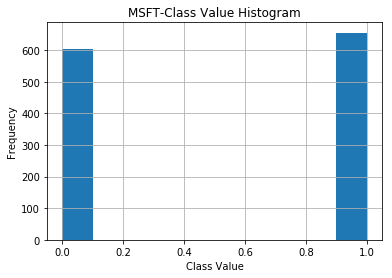

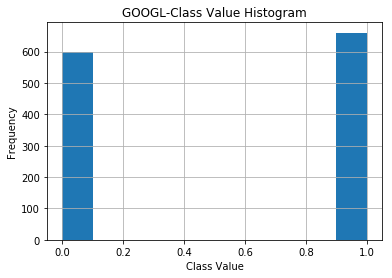

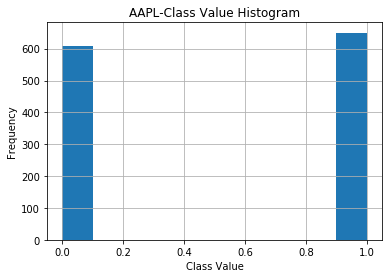

In [80]:
def check_class_balance(dataframes=[df_MSFT, df_AAPL, df_GOOGL]):
    for df in dataframes:
        print(df["target"].value_counts())
        plt.figure()
        df["target"].hist()
        plt.xlabel('Class Value')
        plt.ylabel('Frequency')
        plt.title(df["Name"][0] + '-Class Value Histogram');
        plt.savefig("./Plots/" + df["Name"][0] + "-Class-Balance-Histogram.jpeg")


check_class_balance()

## 1.6.1 | TEST: Seaborn plot correlations with target

Ergebnis: volatility-volume stark pos. korreliert (0.45), ohlc_avg-volume mäßig neg. korreliert (-0.36)

<Figure size 432x288 with 0 Axes>

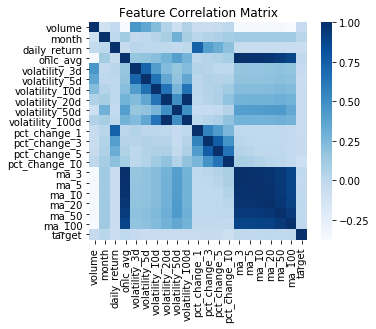

<Figure size 432x288 with 0 Axes>

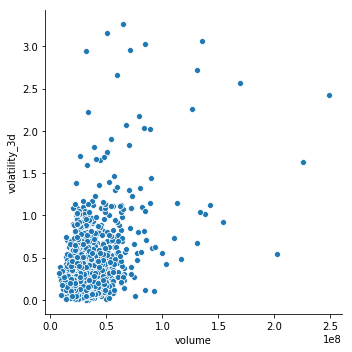

<Figure size 432x288 with 0 Axes>

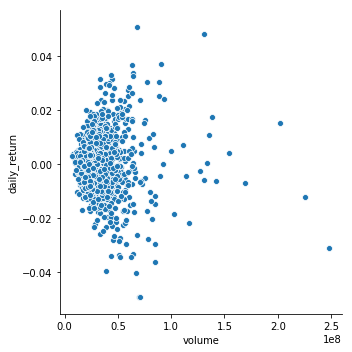

<Figure size 432x288 with 0 Axes>

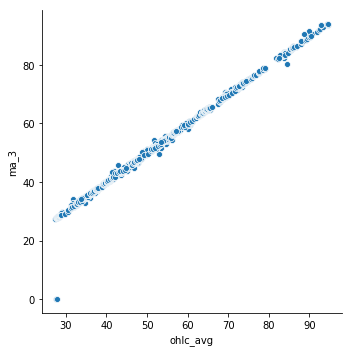

In [98]:
def plot_corr_sns(df):
    df = df.drop(columns=["open", "high", "low", "close"])
    corr = df.corr()
    
    plt.figure()
    f, ax = plt.subplots(figsize=(5, 4)) #PARAM: figsize=(15, 12)
    ax.set_title("Feature Correlation Matrix")
    sns.heatmap(corr, cmap=plt.cm.Blues, mask=np.zeros_like(corr, dtype=np.bool), square=True, ax=ax)
    # plt.savefig("./plots/DataPreparation_MSFT-Stock-Data_correlation-matrix_v4.jpeg")
    
    plt.figure()
    sns.relplot(x="volume", y="volatility_3d", data=df);
    
    plt.figure()
    sns.relplot(x="volume", y="daily_return", data=df);
    
    plt.figure()
    sns.relplot(x="ohlc_avg", y="ma_3", data=df);


plot_corr_sns(df_MSFT)
# Add other df's

In [ ]:
tbc